## Import Packages to Extract and Present Data

In [1]:
# for data processing
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
# for coloring heatmap later
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

# for dealing with dates
import datetime

# for dealing with environment variables
import os

# For parsing financial data from financialmodelingprep api
from urllib.request import urlopen
import json
def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Financialmodelingprep api url
base_url = "https://financialmodelingprep.com/api/v3/"

## Enter  Financial Modeling Prep API Key and Ticker, to Obtain Financial Statements Data

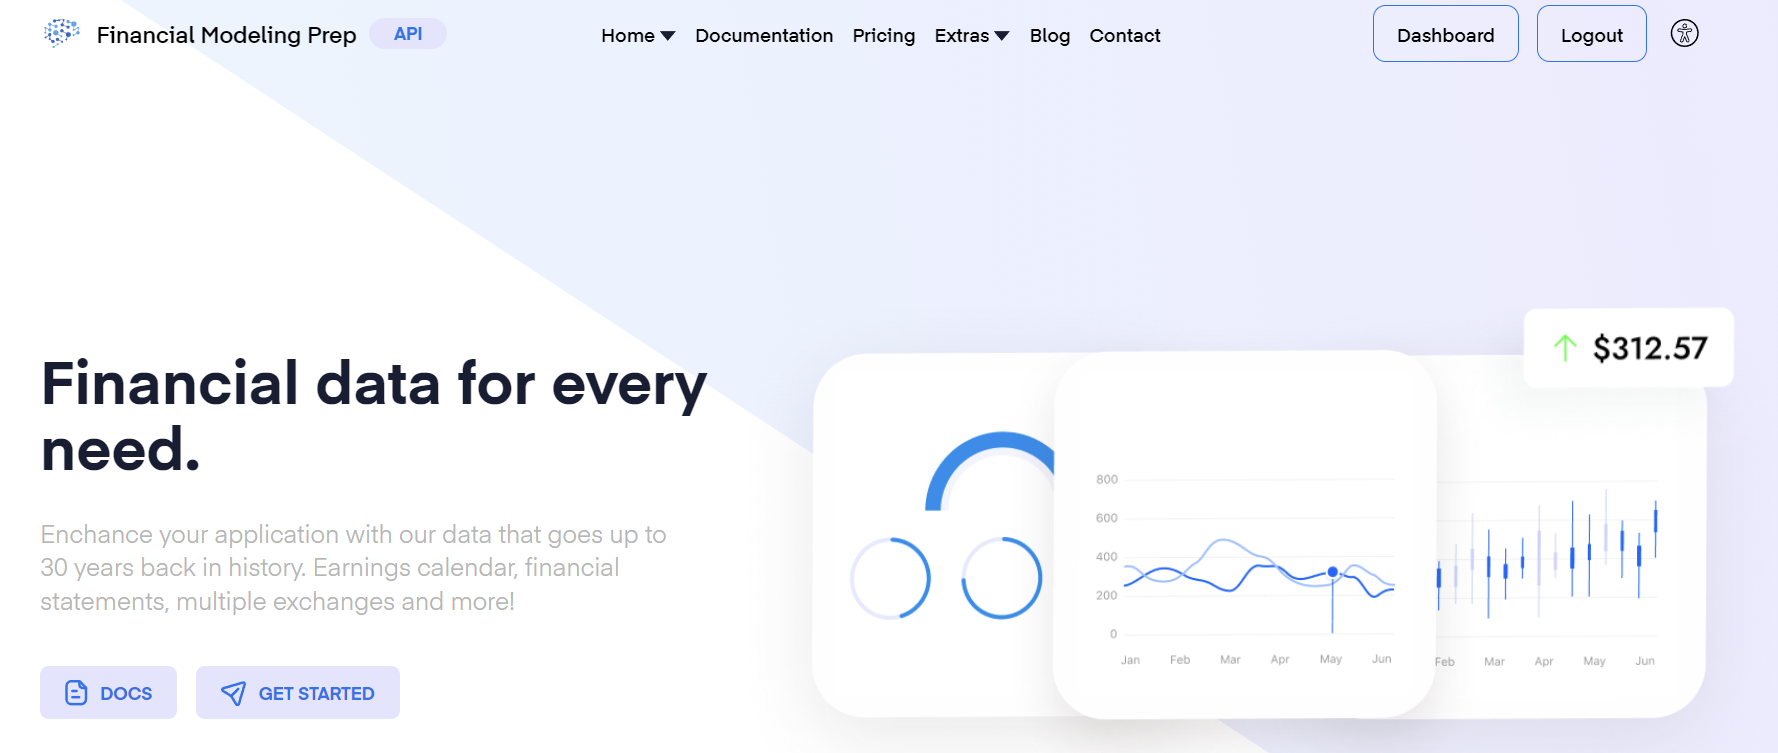

The Financial Modeling Prep (FMP) API is an accurate financial data (i.e. stocks, earnings, historical data, market sentiment, financial statements etc.) API. You need to obtain the Financial Modeling Prep (FMP) API key (sign up [here](https://intelligence.financialmodelingprep.com/pricing-plans?couponCode=damianboh&utm_campaign=damianboh&utm_medium=blog&utm_source=medium)).

There is a free version where you can get 250 calls per day for free, which is more than enough to run the steps below.

In [2]:
# uncomment and enter API Key below
# os.environ['FMP_API_KEY'] = "your_api_key"
apiKey = os.environ['FMP_API_KEY']

# Enter Ticker of Interest Below

In [3]:
ticker = "META"
ticker = ticker.upper() # make sure ticker is caps

# Obtain Earnings Releases Data from FMP API

The endpoint https://financialmodelingprep.com/api/v3/earnings-surprises/{ticker}?apikey={apiKey} gives you both the estimated earnings and actual earning results for all earnings releases of any ticker you are interested in.

You can read more about it on the FMP website https://site.financialmodelingprep.com/developer/docs#earnings-surprises-earnings

Once again you can sign up for the API at a discounted rate [here](https://intelligence.financialmodelingprep.com/pricing-plans?couponCode=damianboh&utm_campaign=damianboh&utm_medium=blog&utm_source=medium).

A sample response is shown below

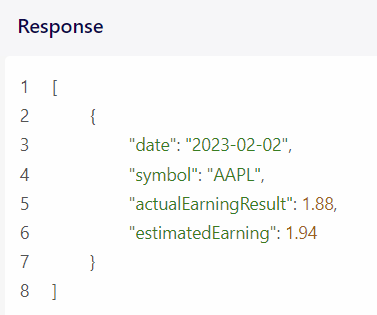


Let's get the earnings data, parse the JSON and convert it into a DataFrame using the code below. We also convert the date column into a Python datetime type and set this as the index so the DataFrame becomes a time series, this is for easier data manipulation later. From the actual earnings and estimated earnings results we will later be able to calculate how much of an earnings surprise there is.

In [4]:
url = f"{base_url}earnings-surprises/{ticker}?apikey={apiKey}"
df_earnings = pd.DataFrame(get_jsonparsed_data(url))
df_earnings['date'] = pd.to_datetime(df_earnings['date']) # changing column to the datetime type
df_earnings = df_earnings.set_index('date') # turn it into time series
df_earnings.head()

,symbol,actualEarningResult,estimatedEarning
date,,,
2023-10-25,META,4.39,3.63
2023-07-26,META,2.98,2.92
2023-04-26,META,2.20,2.03
2023-02-01,META,3.00,2.12
2022-10-26,META,1.64,1.89


# Get Stock Prices

This FMP API endpoint https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?from={earliest_date_string}&apikey={apikey} allows you to get all the stock prices from the earliest date that you want, for any ticker.

A screenshot of the API response from the FMP documentation https://site.financialmodelingprep.com/developer/docs#daily-chart-charts is shown below.

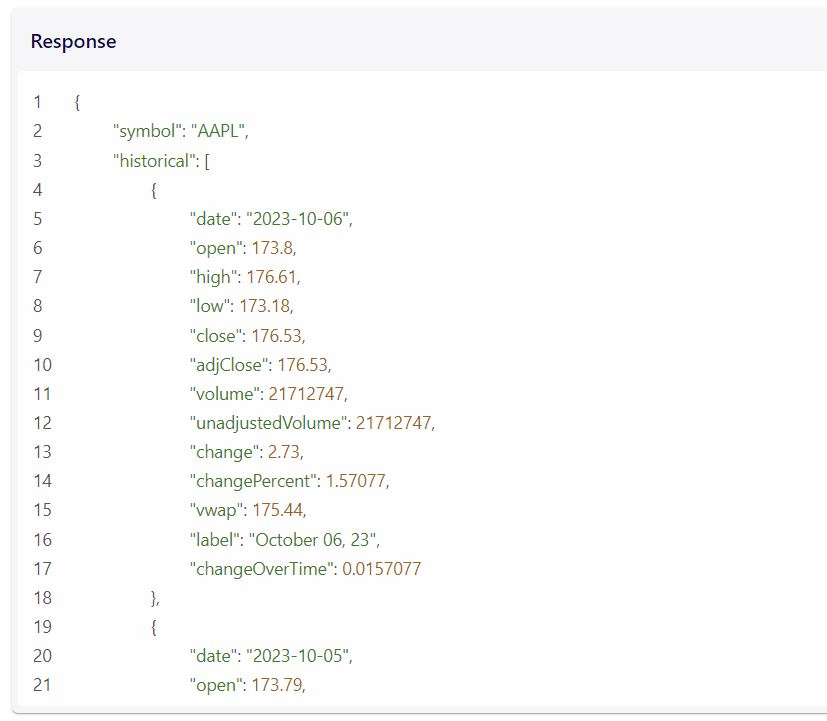


We do not need to get all historical stock prices, but only the one from the earliest earnings date, to eventually perform our correlation later. Hence we get the earliest date of earnings (which is the index of the last row of the df_earnings DataFrame), this is the earliest date from which we will scrape the stock prices. We also need to convert this date into a string to pass to the FMP API url endpoint later.

In [5]:
earliest_date = df_earnings.index[-1] # index of last row is the earliest earnings date in the data
earliest_date_string = earliest_date.strftime('%Y-%m-%d') # convert date to string

Similar to how we obtain the earnings data, we get the prices data, parse the JSON, convert it into a DataFrame and set the date column as the index.

In [6]:
url = f"{base_url}historical-price-full/{ticker}?from={earliest_date_string}&apikey={apiKey}" # url to scrape prices for ticker, from earliest_date_string
df_prices = pd.DataFrame(get_jsonparsed_data(url)['historical']) # the 'historical' key allows us to get historical prices, see the screenshot of the JSON that the API returns above
df_prices['date'] = pd.to_datetime(df_prices['date'])  # changing column to the datetime type
df_prices = df_prices.set_index('date') # turn it into time series
df_prices

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2023-11-20,334.89,341.87,334.19,339.97,339.97,16737643,15336183,5.08,1.52000,339.15,"November 20, 23",0.015200
2023-11-17,330.26,335.50,329.35,335.04,335.04,14519213,14494400,4.78,1.45000,333.73,"November 17, 23",0.014500
2023-11-16,329.37,334.58,326.38,334.19,334.19,18922572,18932600,4.82,1.46000,331.09,"November 16, 23",0.014600
2023-11-15,337.93,338.40,330.02,332.71,332.71,14531180,14531200,-5.22,-1.54000,333.81,"November 15, 23",-0.015400
2023-11-14,334.54,338.10,333.33,336.31,336.31,17179403,17179400,1.77,0.52908,335.66,"November 14, 23",0.005291
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-01,21.50,21.58,20.84,20.88,20.88,44604400,44604400,-0.62,-2.88000,21.10,"August 01, 12",-0.028800
2012-07-31,23.37,23.37,21.61,21.71,21.71,56179400,56179400,-1.66,-7.10000,22.23,"July 31, 12",-0.071000
2012-07-30,24.00,24.04,23.03,23.15,23.15,29285900,29285900,-0.85,-3.54000,23.41,"July 30, 12",-0.035400


# Shift the Prices to Correspond to Future Prices
With our stock prices DataFrame, we eventually want to see how the prices change 1 day to 1 month after earnings release. Hence we want to create columns for future prices of the stock. Fortunately, with a time series DataFrame, this process is easy, all we need to do is to use the .shift() method as shown in the code below to shift the prices forward by the number of days we want. Here I shift the time series DataFrame to look at the 1 day, 2 day, 3 day, 1 week and 1 month future prices, feel free to change it to any day you want.

Remember that the days shifted correspond to working days where there is trading (for example, there are about 20 working days in a month, 5 working days in a week, as reflected in the code below. Note that we are using the adjusted closing price (adjClose column) for each day to be the stock price. This is the closing price adjusted for things like stock splits etc. throughout history.

In the resulting DataFrame, notice that there are missing rows at the top of each column. For example, the 3_day future prices column has 3 missing rows. This is normal because we do not know what the prices are 3 days later, in each of the most recent 3 days as this refers to days in the future (I hope this makes sense!). This means that we may not have enough pricing data to see how the price is affected by the latest earnings results if the releases are too recent. That is fine because our correlation score will be averaged over the whole historical time period and the missing data will be ignored.

In [7]:
df_prices['day_0'] = df_prices['adjClose']
df_prices['1_day'] = df_prices.shift(1)['adjClose']
df_prices['2_day'] = df_prices.shift(2)['adjClose']
df_prices['3_day'] = df_prices.shift(3)['adjClose']
df_prices['1_week'] = df_prices.shift(5)['adjClose'] # 1 week is 5 working days
df_prices['1_month'] = df_prices.shift(20)['adjClose'] # 1 month ~ 20 working days
df_prices[['day_0', '1_day', '2_day', '3_day', '1_week', '1_month']]

,day_0,1_day,2_day,3_day,1_week,1_month
date,,,,,,
2023-11-20,339.97,NaN,NaN,NaN,NaN,NaN
2023-11-17,335.04,339.97,NaN,NaN,NaN,NaN
2023-11-16,334.19,335.04,339.97,NaN,NaN,NaN
2023-11-15,332.71,334.19,335.04,339.97,NaN,NaN
2023-11-14,336.31,332.71,334.19,335.04,NaN,NaN
...,...,...,...,...,...,...
2012-08-01,20.88,20.04,21.09,21.92,20.72,19.10
2012-07-31,21.71,20.88,20.04,21.09,20.72,19.34
2012-07-30,23.15,21.71,20.88,20.04,21.92,19.15


# Merge the Earnings and Prices Data from the Above Together
Now that we have the both the earnings and pricing data, we can join them together by matching them on the index (dates) columns on both DataFrames.

In [8]:
df = df_earnings.merge(df_prices[['day_0', '1_day', '2_day', '3_day', '1_week', '1_month']],
                       left_index = True, right_index = True, how = 'left')

df.head()

,symbol,actualEarningResult,estimatedEarning,day_0,1_day,2_day,3_day,1_week,1_month
date,,,,,,,,,
2023-10-25,META,4.39,3.63,299.53,288.35,296.73,302.66,311.85,NaN
2023-07-26,META,2.98,2.92,298.57,311.71,325.48,318.60,314.31,294.24
2023-04-26,META,2.20,2.03,209.40,238.56,240.32,243.18,237.03,249.21
2023-02-01,META,3.00,2.12,153.12,188.77,186.53,186.06,183.43,174.53
2022-10-26,META,1.64,1.89,129.82,97.94,99.20,93.16,90.54,112.24


# Calculate % Difference in Actual Earnings from Estimated Earnings, and % Difference in Future Prices from Current Prices

Having the earnings results and stock prices themselves are not enough, we still need to do a bit of processing as we want to see the correlation between earnings surprises and change in prices. Here we calculate the % difference in actual earnings vs estimated earnings, and also the % difference in future prices from current prices 1 day, 2 day, 3 day, 1 week and 1 month later using the corresponding future prices columns.

In [9]:
df['earnings_diff'] = (df['actualEarningResult'] - df['estimatedEarning'])/df['estimatedEarning']
df['1_day_diff'] = (df['1_day'] - df['day_0'])/df['day_0']
df['2_day_diff'] = (df['2_day'] - df['day_0'])/df['day_0']
df['3_day_diff'] = (df['3_day'] - df['day_0'])/df['day_0']
df['1_week_diff'] = (df['1_week'] - df['day_0'])/df['day_0']
df['1_month_diff'] = (df['1_month'] - df['day_0'])/df['day_0']

df[['earnings_diff', '1_day_diff', '2_day_diff', '3_day_diff', '1_week_diff', '1_month_diff']].head()

,earnings_diff,1_day_diff,2_day_diff,3_day_diff,1_week_diff,1_month_diff
date,,,,,,
2023-10-25,0.209366,-0.037325,-0.009348,0.010450,0.041131,NaN
2023-07-26,0.020548,0.044010,0.090130,0.067086,0.052718,-0.014502
2023-04-26,0.083744,0.139255,0.147660,0.161318,0.131948,0.190115
2023-02-01,0.415094,0.232824,0.218195,0.215125,0.197949,0.139825
2022-10-26,-0.132275,-0.245571,-0.235865,-0.282391,-0.302573,-0.135418


# Plot % Diff in Future Prices vs % Diff in Expected/Actual Earnings in a Scatterplot

We finally ready to see if there is any correlation between the earnings surprises (% diff in expected/actual earnings) and the price movement (% diff in future/current prices after earnings). Let's plot these on a scatterplot and fit a regression line to it as well to see if there is any pattern.

<AxesSubplot:xlabel='earnings_diff', ylabel='1_day_diff'>

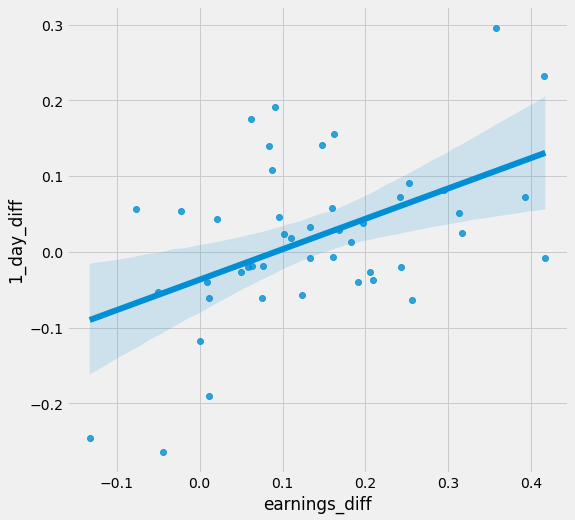

In [10]:
plt.rcParams["figure.figsize"] = (8,8)
sns.regplot(data=df, x="earnings_diff", y="1_day_diff")

From these plots, it seems like there is indeed some positive correlation between the earnings difference and change in prices after earnings over all the time periods we are interested in (i.e. positive earnings surprises result in positive price changes). At least this is the case for Meta stock.

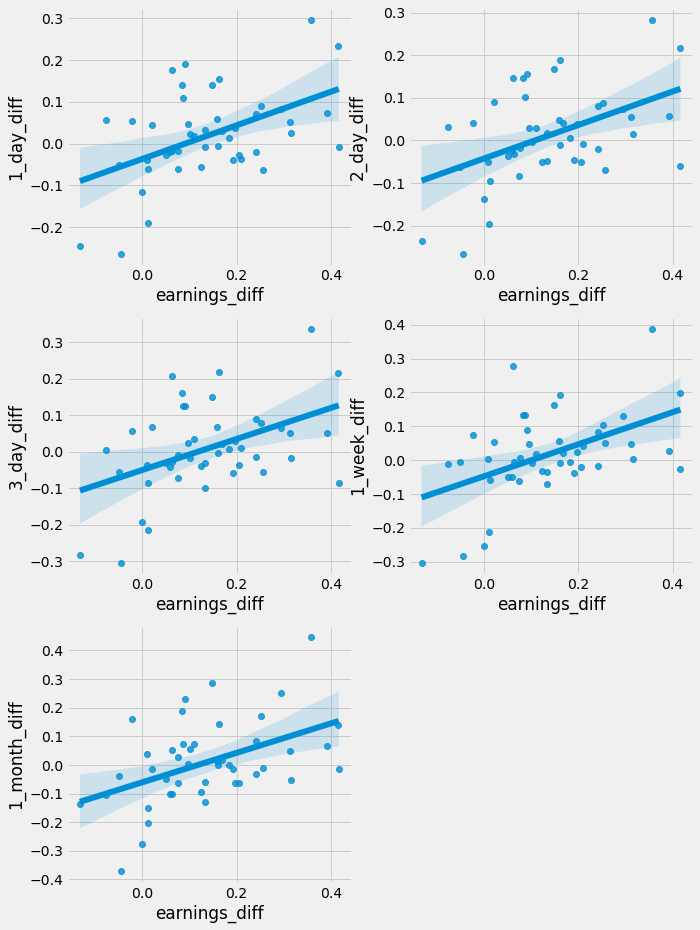

In [11]:
plt.rcParams["figure.figsize"] = (10,15)

plt.subplot(3, 2, 1)
sns.regplot(data=df, x="earnings_diff", y="1_day_diff")

plt.subplot(3, 2, 2)
sns.regplot(data=df, x="earnings_diff", y="2_day_diff")

plt.subplot(3, 2, 3)
sns.regplot(data=df, x="earnings_diff", y="3_day_diff")

plt.subplot(3, 2, 4)
sns.regplot(data=df, x="earnings_diff", y="1_week_diff")

plt.subplot(3, 2, 5)
sns.regplot(data=df, x="earnings_diff", y="1_month_diff")


plt.show()

# Calculate Correlation Between the DataFrame Columns, and Plot Out On a Heatmap

Let's now calculate the correlation between the earnings_diff column and all the price difference columns. We can do this using the .corr() method for the DataFrame, which returns the correlation score between every pair of columns in the DataFrame in a matrix shown below.

We also plot out the correlation matrix on a heatmap and defined a color palette to use red for negative, green for positive, and white for 0 correlation values. In our case, we only want the first row (or column) of the matrix as we are not interested in the correlation between the price difference columns themselves.

<AxesSubplot:>

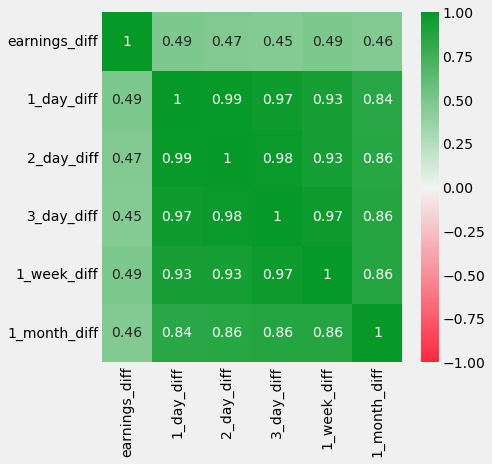

In [12]:
plt.rcParams["figure.figsize"] = (6,6)

# define color palette, here we define red for negative, green for positive and white for 0
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
divnorm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

df_corr = df[['earnings_diff', '1_day_diff', '2_day_diff', '3_day_diff', '1_week_diff', '1_month_diff']].corr()
sns.heatmap(df_corr, annot=True, norm=divnorm, cmap=rdgn)

# Repeat All Steps Above and Put the Code Together for Different Tickers

The following code loops through multiple tickers of interest (feel free to change the list of tickers to your favorite ones), repeats all the above steps and extracts the first row of the correlation matrix. Then it combines all these rows together into a final summary DataFrame of correlation scores between earnings surprises and price movement for each time period, for each ticker.

In [13]:
tickers = ['GOOG', 'META', 'AAPL', 'MSFT', 'NVDA', 'NFLX', 'V', 'MA', 'AMZN',
 'TSLA', 'JPM', 'BAC', 'C', 'BA', 'MMM', 'HON', 'CRM', 'PLTR', 'VEEV', 'JNJ', 'UNH', 'BABA']

In [14]:
df_all = pd.DataFrame() # to store results for all tickers

for ticker in tickers:
    print("Scraping Earnings Surprises and Stock Prices for", ticker)

    # scrape earnings surprises from FMP API
    url = f"{base_url}earnings-surprises/{ticker}?apikey={apiKey}"
    df_earnings = pd.DataFrame(get_jsonparsed_data(url))
    df_earnings['date'] = pd.to_datetime(df_earnings['date'])
    df_earnings = df_earnings.set_index('date')

    # scrape stock prices from FMP API
    earliest_date = df_earnings.index[-1]
    earliest_date_string = earliest_date.strftime('%Y-%m-%d')
    url = f"{base_url}historical-price-full/{ticker}?from={earliest_date_string}&apikey={apiKey}"
    df_prices = pd.DataFrame(get_jsonparsed_data(url)['historical'])
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date')
    df_prices['day_0'] = df_prices['adjClose']
    df_prices['1_day'] = df_prices.shift(1)['adjClose']
    df_prices['2_day'] = df_prices.shift(2)['adjClose']
    df_prices['3_day'] = df_prices.shift(3)['adjClose']
    df_prices['1_week'] = df_prices.shift(5)['adjClose']
    df_prices['1_month'] = df_prices.shift(20)['adjClose']

    # merge the data
    df = df_earnings.merge(df_prices[['day_0', '1_day', '2_day', '3_day', '1_week', '1_month']],
                           left_index = True, right_index = True, how = 'left')
    df['earnings_diff'] = (df['actualEarningResult'] - df['estimatedEarning'])/df['estimatedEarning']
    df['1_day_diff'] = (df['1_day'] - df['day_0'])/df['day_0']
    df['2_day_diff'] = (df['2_day'] - df['day_0'])/df['day_0']
    df['3_day_diff'] = (df['3_day'] - df['day_0'])/df['day_0']
    df['1_week_diff'] = (df['1_week'] - df['day_0'])/df['day_0']
    df['1_month_diff'] = (df['1_month'] - df['day_0'])/df['day_0']

    # calculate correlation
    df_all[f'{ticker}'] = df[['earnings_diff', '1_day_diff', '2_day_diff', '3_day_diff',
                                            '1_week_diff', '1_month_diff']].corr()[['earnings_diff']]

df_all

Scraping Earnings Surprises and Stock Prices for GOOG
Scraping Earnings Surprises and Stock Prices for META
Scraping Earnings Surprises and Stock Prices for AAPL
Scraping Earnings Surprises and Stock Prices for MSFT
Scraping Earnings Surprises and Stock Prices for NVDA
Scraping Earnings Surprises and Stock Prices for NFLX
Scraping Earnings Surprises and Stock Prices for V
Scraping Earnings Surprises and Stock Prices for MA
Scraping Earnings Surprises and Stock Prices for AMZN
Scraping Earnings Surprises and Stock Prices for TSLA
Scraping Earnings Surprises and Stock Prices for JPM
Scraping Earnings Surprises and Stock Prices for BAC
Scraping Earnings Surprises and Stock Prices for C
Scraping Earnings Surprises and Stock Prices for BA
Scraping Earnings Surprises and Stock Prices for MMM
Scraping Earnings Surprises and Stock Prices for HON
Scraping Earnings Surprises and Stock Prices for CRM
Scraping Earnings Surprises and Stock Prices for PLTR
Scraping Earnings Surprises and Stock Price

,GOOG,META,AAPL,MSFT,NVDA,NFLX,V,MA,AMZN,TSLA,...,C,BA,MMM,HON,CRM,PLTR,VEEV,JNJ,UNH,BABA
earnings_diff,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1_day_diff,0.190873,0.487504,0.233870,0.131771,0.238718,0.095687,-0.084767,0.071928,0.248161,-0.030266,...,0.043714,0.068924,0.014406,0.068561,0.070082,0.146225,0.108669,0.009521,-0.034335,-0.143390
2_day_diff,0.206034,0.468824,0.170659,0.151420,0.212296,0.115276,-0.115029,0.170392,0.232239,-0.060732,...,0.015946,0.149459,0.015755,0.059537,0.025798,0.181270,0.053653,0.006119,0.003138,-0.064336
3_day_diff,0.192101,0.454094,0.122219,0.136139,0.163569,0.093401,-0.136901,0.178066,0.245158,0.003618,...,-0.007354,0.207526,-0.049155,-0.044054,0.046986,0.395695,0.084774,0.052308,0.035899,-0.157246
1_week_diff,0.276858,0.486941,0.107513,0.159813,0.220363,0.131027,-0.067352,0.176156,0.241114,0.004540,...,-0.097352,0.263717,-0.058351,-0.062030,0.075429,0.422992,0.092972,0.058474,0.073517,-0.096336
1_month_diff,0.208697,0.463366,0.066005,0.111618,0.179157,0.194120,-0.062097,0.010072,0.229037,0.195056,...,-0.208409,0.221126,-0.159464,-0.161271,0.109065,0.342851,0.106205,-0.048170,0.009917,0.166488


We then sort the summary DataFrame of correlation scores by the 1_day_diff correlation with the earnings surprises, starting from highest to lowest. We also calculate the average scores for each ticker in the final row.

In [15]:
df_summary = df_all.T
df_summary = df_summary.iloc[:, 1:]
df_summary = df_summary.sort_values('1_day_diff', ascending = False)
df_summary.loc['Average'] = df_summary.mean()
df_summary

,1_day_diff,2_day_diff,3_day_diff,1_week_diff,1_month_diff
META,0.487504,0.468824,0.454094,0.486941,0.463366
AMZN,0.248161,0.232239,0.245158,0.241114,0.229037
NVDA,0.238718,0.212296,0.163569,0.220363,0.179157
AAPL,0.233870,0.170659,0.122219,0.107513,0.066005
GOOG,0.190873,0.206034,0.192101,0.276858,0.208697
PLTR,0.146225,0.181270,0.395695,0.422992,0.342851
MSFT,0.131771,0.151420,0.136139,0.159813,0.111618
VEEV,0.108669,0.053653,0.084774,0.092972,0.106205
NFLX,0.095687,0.115276,0.093401,0.131027,0.194120
MA,0.071928,0.170392,0.178066,0.176156,0.010072


# Heatmap Plot of Correlation Between Earnings Surprises and Stock Price Movements

Next, we plot the above summary DataFrame into a heatmap, using the same color scheme as defined earlier.

<AxesSubplot:title={'center':'Heatmap Plot of Correlation Between Earnings Surprises and Stock Price Movements'}>

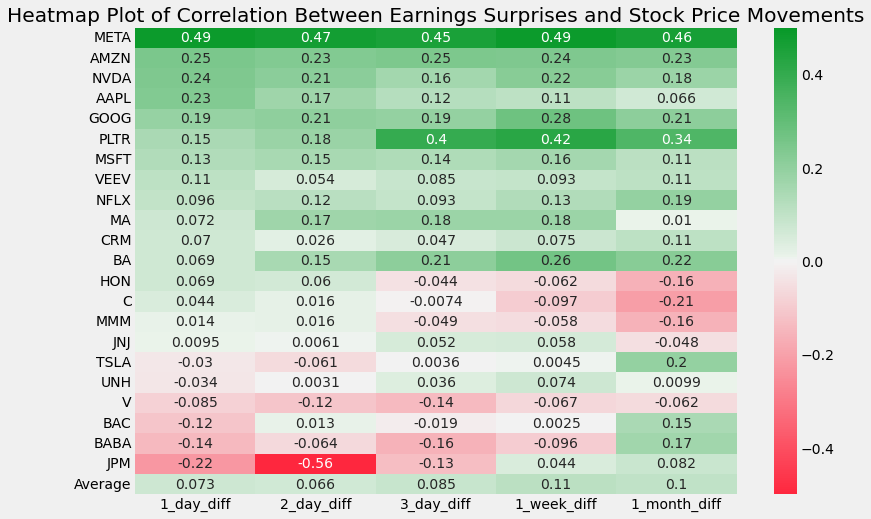

In [16]:
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
divnorm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

plt.rcParams["figure.figsize"] = (12,8)
plt.title('Heatmap Plot of Correlation Between Earnings Surprises and Stock Price Movements')
sns.heatmap(df_summary, annot=True, norm=divnorm, cmap=rdgn)

Here we can see that the magnificent 7 stocks (except for TSLA) are among the top few in terms of correlation between earnings surprises and stock price movements. This is not surprising as I assume that there will be many news articles written on these companies whenever they release earnings. There may be many people trading these companies as well. These people may be eager about their results and respond accordingly to buy/sell the stocks whenever they have positive/negative earning surprises.

The healthcare and defensive stocks (e.g. HON, MMM, JNJ, UNH) are in the middle rows, meaning they have very small correlation values (neither positive nor negative). This is also expected as prices of defensive stocks tend to be more stable and perhaps more people invest in the stocks long term to hold through both good and tough times rather than trade them. Their earnings may tend to be more predictable and stable, hence the reaction to the earnings may not be as strong.

Interestingly the bank stocks (e.g. BAC, JPM) have negative correlation scores. Perhaps people always expect even more earnings even if they beat the expected earnings, resulting in a sell down anyway? I am not sure! But I'm sure some of you would have observed these days that China stocks like BABA seem to have good fundamentals and produce positive earnings beat, yet sadly continue to have their stock prices beaten up. This is reflected in our heatmap above in that BABA is indeed in one of the last few rows with a negative correlation between earnings surprises and price movements!